# 載入所需套件

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
from datetime import datetime,timedelta
%matplotlib inline

style.use('seaborn')
register_matplotlib_converters()
#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

# 定義抓取指定時間範圍富邦VIX淨值函數

In [2]:
def fubon_vix_nav_crawlwr(startdate,enddate):
    url='https://websys.fsit.com.tw/FubonETF/Trade/PremiumDiscount.aspx'
    session=requests.session()
    response=session.get(url)
    soup=BeautifulSoup(response.text,'html.parser')
    VIEWSTATE=soup.select_one('#__VIEWSTATE')['value']
    VIEWSTATEGENERATOR=soup.select_one('#__VIEWSTATEGENERATOR')['value']
    VIEWSTATEENCRYPTED=soup.select_one('#__VIEWSTATEENCRYPTED')['value']
    EVENTVALIDATION=soup.select_one('#__EVENTVALIDATION')['value']
    startdate=startdate.strftime('%Y/%m/%d')
    enddate=enddate.strftime('%Y/%m/%d')

    form_data={
        '__VIEWSTATE':VIEWSTATE,
        '__VIEWSTATEGENERATOR':VIEWSTATEGENERATOR,
        '__VIEWSTATEENCRYPTED':VIEWSTATEENCRYPTED,
        '__EVENTVALIDATION':EVENTVALIDATION,
        'ctl00$ctl00$MainContent$main$cbx_funds$26':'62',
        'ctl00$ctl00$MainContent$main$tbx_sdate':startdate,
        'ctl00$ctl00$MainContent$main$tbx_edate':enddate,
        'ctl00$ctl00$MainContent$main$btm_search':'查詢'
    }

    response=session.post(url,data=form_data)
    df=pd.read_html(response.text)[3]
    df['時間']=pd.to_datetime(df['時間'].apply(lambda x:x[:10]))
    df['折溢價幅']=df['折溢價幅'].apply(lambda x:float(x[:-1]))
    df.set_index('時間',inplace=True)
    
    return df

# 定義繪製富邦VIX歷史淨值和溢價圖函數

In [3]:
def plot_fubon_vix_nav():
    fig,ax=plt.subplots(1,figsize=(15,6))
    ax2=ax.twinx()
    ax.plot(df.index,df['估計淨值'],label='歷史淨值')
    ax2.plot(df.index,df['折溢價幅'],label='溢價幅度(%)',color='#ff7f0e')
    lines=ax.get_lines()+ax2.get_lines()
    ax.legend(lines,[line.get_label() for line in lines],fontsize=15,loc='upper left')
    ax.set_title('富邦VIX歷史淨值和溢價圖',fontsize=18)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylabel('歷史淨值',fontsize=11,rotation=0)
    ax.yaxis.set_label_coords(-0.02,1)
    ax2.set_ylabel('溢價幅度(%)',fontsize=11,rotation=0)
    ax2.yaxis.set_label_coords(1.02,1.03)
    ax2.tick_params(axis='y',labelsize=12)
    plt.savefig('富邦VIX歷史淨值和溢價圖.png')
    plt.show()

# 抓取近一年富邦VIX淨值資料

In [4]:
enddate=datetime.now().date()
startdate=(enddate-timedelta(days=365))
df=fubon_vix_nav_crawlwr(startdate,enddate)

df.head()

,名稱,估計淨值,成交價格,折溢價幅
時間,,,,
2019-07-08,富邦VIX,4.57,4.96,8.53
2019-07-09,富邦VIX,4.70,4.97,5.74
2019-07-10,富邦VIX,4.63,4.93,6.48
2019-07-11,富邦VIX,4.42,4.87,10.18
2019-07-12,富邦VIX,4.38,4.90,11.87


# 將近一年富邦VIX淨值資料匯出成Excel檔

In [5]:
df.to_excel('近一年富邦VIX淨值資料.xlsx')

# 繪製富邦VIX歷史淨值和溢價圖

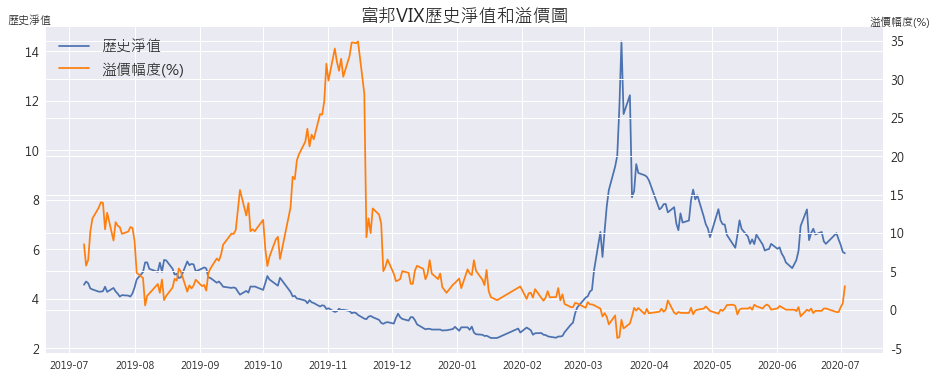

In [6]:
plot_fubon_vix_nav()